In [3]:
# # 1. Check your PyTorch + CUDA versions:
# import torch
# print(torch.__version__)        # e.g. 2.0.1+cu118
# print(torch.version.cuda)       # e.g. 11.8

# # 2. Install PyG C-extensions + torch-geometric:
# CUDA = torch.version.cuda.replace('.', '')  # e.g. '118'
# TORCH = torch.__version__.split('+')[0]      # e.g. '2.0.1'
# WHL_URL = f"https://data.pyg.org/whl/torch-{TORCH}+cu{CUDA}.html"

# # Run these in Colab:
# !pip install torch-scatter -f {WHL_URL}
# !pip install torch-sparse  -f {WHL_URL}
# !pip install torch-cluster -f {WHL_URL}
# !pip install torch-spline-conv -f {WHL_URL}
# !pip install pyg-lib       -f {WHL_URL}
# !pip install torch-geometric

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
from torch_geometric.utils import structured_negative_sampling

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [4]:
# Downloading the data set
from torch_geometric.data import download_url, extract_zip

DATA_URL = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
DATA_DIR = './dataset'

archive_path = download_url(DATA_URL, DATA_DIR)
extract_zip(archive_path, DATA_DIR)

Using existing file ml-latest-small.zip
Extracting ./dataset/ml-latest-small.zip


In [5]:
# Load and preview MovieLens data
movies_csv_path = './dataset/ml-latest-small/movies.csv'
ratings_csv_path = './dataset/ml-latest-small/ratings.csv'

movies_df = pd.read_csv(movies_csv_path, index_col='movieId')
ratings_df = pd.read_csv(ratings_csv_path)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# Split out genres
genres_expanded = movies_df['genres'].str.get_dummies(sep='|')
movies_onehot = movies_df.join(genres_expanded).drop(columns=['genres'])
movies_onehot.head()

,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Each rating = a positive link
pos_df = (
    ratings_df[['userId','movieId']]
    .rename(columns={'userId':'user', 'movieId':'movie'})
    .assign(link_exists=1)
    .merge(movies_onehot, left_on='movie', right_index=True)
)
pos_df.head()

,user,movie,link_exists,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,1,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,Grumpier Old Men (1995),0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,6,1,Heat (1995),0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,1,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,1,"Usual Suspects, The (1995)",0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [8]:
# All (user, movie) pairs that were NOT rated
all_users  = ratings_df['userId'].unique()
all_movies = ratings_df['movieId'].unique()

# build set of existing pairs
existing = set(zip(ratings_df['userId'], ratings_df['movieId']))

neg_samples = []
rng = np.random.default_rng(42)
while len(neg_samples) < len(pos_df):
    u = rng.choice(all_users)
    m = rng.choice(all_movies)
    if (u,m) not in existing:
        neg_samples.append((u,m))
neg_df = (
    pd.DataFrame(neg_samples, columns=['user','movie'])
    .assign(link_exists=0)
    .merge(movies_onehot, left_on='movie', right_index=True)
)
neg_df.head()

,user,movie,link_exists,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,55,5422,0,"Emperor's New Clothes, The (2001)",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,400,3310,0,"Kid, The (1921)",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,265,7092,0,Anna Karenina (1935),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,53,54185,0,Manufactured Landscapes (2006),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,123,68954,0,Up (2009),0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
merged_df = pd.concat([pos_df, neg_df], ignore_index=True)
merged_df.head()
merged_df.tail()

,user,movie,link_exists,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
201667,98,121099,0,101 Dalmatians II: Patch's London Adventure (2...,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
201668,107,7767,0,"Best of Youth, The (La meglio gioventù) (2003)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
201669,292,3664,0,Puppet Master 5: The Final Chapter (1994),0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
201670,75,90343,0,Footloose (2011),0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
201671,201,3051,0,Anywhere But Here (1999),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
print("Shape:", merged_df.shape)
print("\nDtypes:\n", merged_df.dtypes)
print("\nMissing values:\n", merged_df.isnull().sum())

Shape: (201672, 24)

Dtypes:
 user                   int64
movie                  int64
link_exists            int64
title                 object
(no genres listed)     int64
Action                 int64
Adventure              int64
Animation              int64
Children               int64
Comedy                 int64
Crime                  int64
Documentary            int64
Drama                  int64
Fantasy                int64
Film-Noir              int64
Horror                 int64
IMAX                   int64
Musical                int64
Mystery                int64
Romance                int64
Sci-Fi                 int64
Thriller               int64
War                    int64
Western                int64
dtype: object

Missing values:
 user                  0
movie                 0
link_exists           0
title                 0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Cr

In [11]:
print("Unique users:", merged_df['user'].nunique())
print("Unique movies:", merged_df['movie'].nunique())

display(merged_df.describe(include='all'))
print("\nClass distribution:\n", merged_df['link_exists'].value_counts(normalize=True))

Unique users: 610
Unique movies: 9724


,user,movie,link_exists,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,201672.000000,201672.000000,201672.000000,201672,201672.000000,201672.000000,201672.000000,201672.000000,201672.000000,201672.000000,...,201672.000000,201672.000000,201672.000000,201672.000000,201672.000000,201672.000000,201672.000000,201672.000000,201672.000000,201672.000000
unique,NaN,NaN,NaN,9719,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Forrest Gump (1994),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,332,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,315.722297,30863.726263,0.500000,NaN,0.002197,0.245458,0.183441,0.065929,0.079009,0.385968,...,0.008697,0.086854,0.028388,0.037769,0.067040,0.171883,0.135869,0.227706,0.044468,0.017930
std,179.599682,46055.846868,0.500001,NaN,0.046817,0.430359,0.387029,0.248158,0.269754,0.486824,...,0.092853,0.281622,0.166078,0.190638,0.250091,0.377280,0.342650,0.419353,0.206134,0.132698
min,1.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,162.000000,1902.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,315.000000,4888.000000,0.500000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,473.000000,52042.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Class distribution:
 link_exists
1    0.5
0    0.5
Name: proportion, dtype: float64


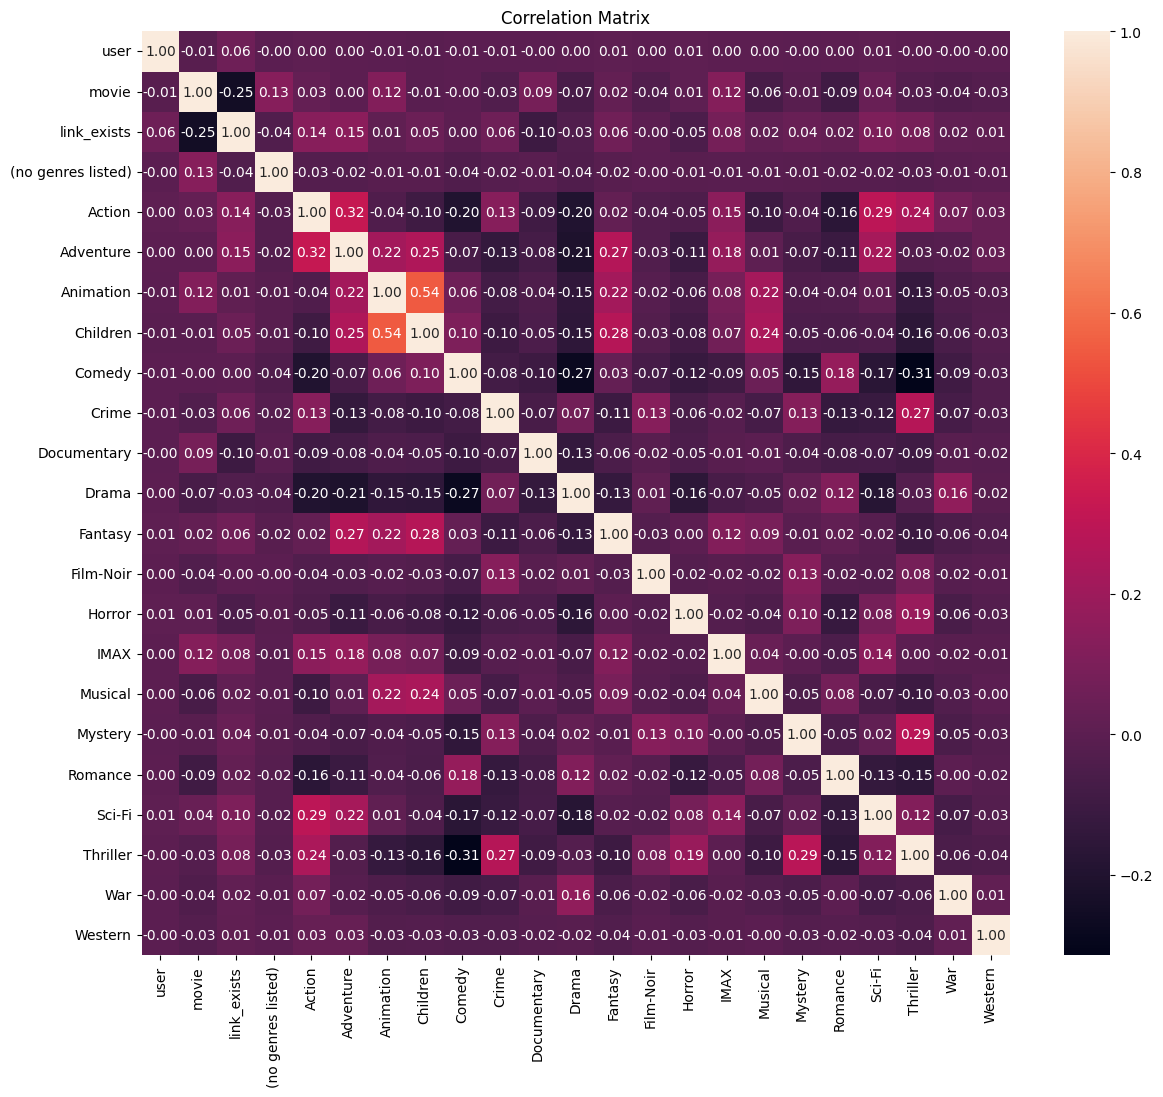

In [12]:
corr = merged_df.drop(columns=['title']).corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

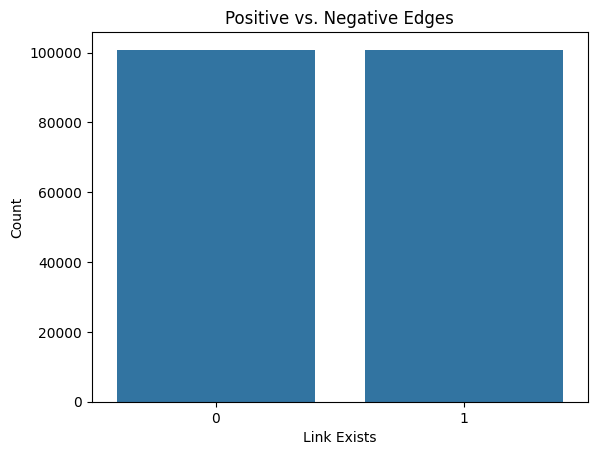

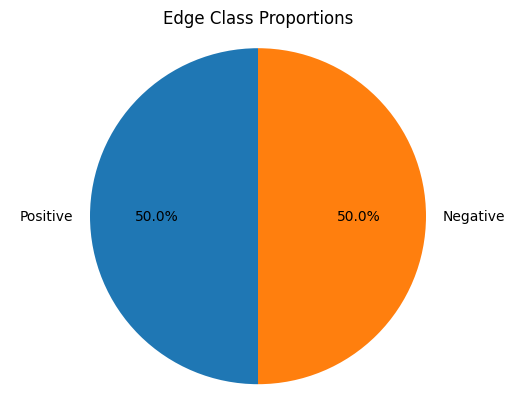

In [13]:
# Countplot
sns.countplot(x='link_exists', data=merged_df)
plt.title("Positive vs. Negative Edges")
plt.xlabel("Link Exists")
plt.ylabel("Count")
plt.show()

# Pie chart
sizes = merged_df['link_exists'].value_counts()
plt.pie(sizes, labels=['Positive','Negative'], autopct='%1.1f%%', startangle=90)
plt.title("Edge Class Proportions")
plt.axis('equal')
plt.show()

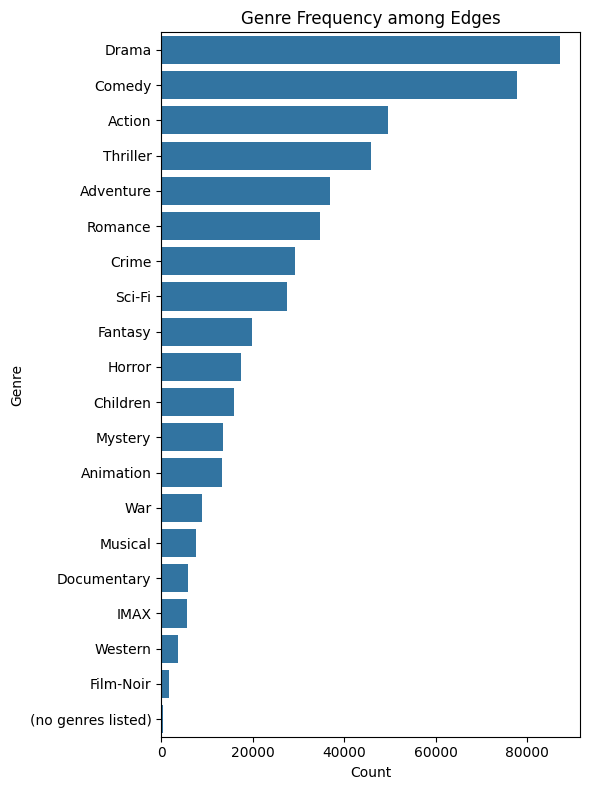

In [14]:
# If you still have `genres_expanded` from your one-hot step:
genre_cols = genres_expanded.columns.tolist()

# Otherwise, pull them straight out of merged_df by excluding the non‐genre cols:
# genre_cols = [c for c in merged_df.columns
#               if c not in ['user','movie','link_exists','title']]

# Now sum and sort
genre_sums = merged_df[genre_cols].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(6,8))
sns.barplot(x=genre_sums.values, y=genre_sums.index)
plt.title("Genre Frequency among Edges")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

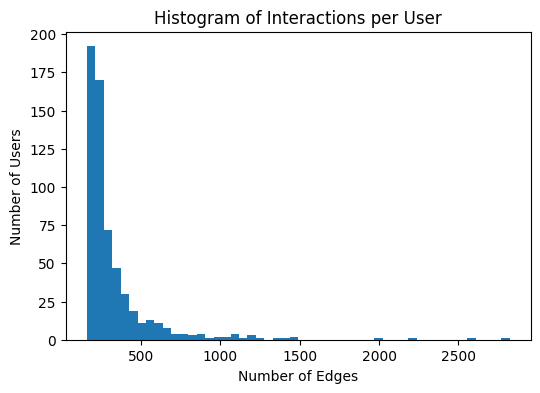

In [15]:
user_counts = merged_df['user'].value_counts()
plt.figure(figsize=(6,4))
plt.hist(user_counts, bins=50)
plt.title("Histogram of Interactions per User")
plt.xlabel("Number of Edges")
plt.ylabel("Number of Users")
plt.show()